# **QFT frequency manipulation**

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister, execute, BasicAer
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import math
%matplotlib inline

In [3]:
# Set up the program
signal = QuantumRegister(4, name='signal')
scratch = QuantumRegister(1, name='scratch')
qc = QuantumCircuit(signal, scratch)

In [4]:
def main():
    ## Prepare a complex sinuisoidal signal
    freq = 2;
    for i in range(len(signal)):
        if (1 << i) & freq:
            qc.x(signal[i]);
    qc.barrier()
    invQFT(signal)

    ## Move to frequency space with QFT
    qc.barrier()
    QFT(signal)

    ## Increase the frequency of signal
    qc.barrier()
    add_int(signal, 1)

    # Move back from frequency space
    qc.barrier()
    invQFT(signal)

In [5]:
def QFT(qreg):
    ## This QFT implementation is adapted from IBM's sample:
    ##   https://github.com/Qiskit/qiskit-terra/blob/master/examples/python/qft.py
    ## ...with a few adjustments to match the book QFT implementation exactly
    n = len(qreg)
    for j in range(n):
        for k in range(j):
            qc.cu1(-math.pi/float(2**(j-k)), qreg[n-j-1], qreg[n-k-1])
        qc.h(qreg[n-j-1])
    # Now finish the QFT by reversing the order of the qubits
    for j in range(n//2):
        qc.swap(qreg[j], qreg[n-j-1])

In [6]:
def invQFT(qreg):
    ## This QFT implementation is adapted from IBM's sample:
    ##   https://github.com/Qiskit/qiskit-terra/blob/master/examples/python/qft.py
    ## ...with a few adjustments to match the book QFT implementation exactly
    n = len(qreg)
    # Start the inverse QFT by reversing the order of the qubits
    for j in range(n//2):
        qc.swap(qreg[j], qreg[n-j-1])

    n = len(qreg)
    for j in range(n):
        for k in range(j):
            qc.cu1(-math.pi/float(2**(j-k)), qreg[j], qreg[k])
        qc.h(qreg[j])

In [7]:
def add_int(qdest, rhs):
    reverse_to_subtract = False
    if rhs == 0:
        return
    elif rhs < 0:
        rhs = -rhs
        reverse_to_subtract = True
    ops = []
    add_val = int(rhs)
    condition_mask = (1 << len(qdest)) - 1

    add_val_mask = 1
    while add_val_mask <= add_val:
        cmask = condition_mask & ~(add_val_mask - 1)
        if add_val_mask & add_val:
            add_shift_mask = 1 << (len(qdest) - 1)
            while add_shift_mask >= add_val_mask:
                cmask &= ~add_shift_mask
                ops.append((add_shift_mask, cmask))
                add_shift_mask >>= 1
        condition_mask &= ~add_val_mask
        add_val_mask <<= 1
    if reverse_to_subtract:
        ops.reverse()
    for inst in ops:
        op_qubits = []
        mask = 1
        for i in range(len(qdest)):
            if inst[1] & (1 << i):
                op_qubits.append(qdest[i])
        for i in range(len(qdest)):
            if inst[0] & (1 << i):
                op_qubits.append(qdest[i])
        multi_cx(op_qubits)

In [8]:
def multi_cz(qubits):
    ## This will perform a CCCCCZ on as many qubits as we want,
    ## as long as we have enough scratch qubits
    multi_cx(qubits, do_cz=True)

In [9]:
def multi_cx(qubits, do_cz=False):
    ## This will perform a CCCCCX with as many conditions as we want,
    ## as long as we have enough scratch qubits
    ## The last qubit in the list is the target.
    target = qubits[-1]
    conds = qubits[:-1]
    scratch_index = 0
    ops = []
    while len(conds) > 2:
        new_conds = []
        for i in range(len(conds)//2):
            ops.append((conds[i * 2], conds[i * 2 + 1], scratch[scratch_index]))
            new_conds.append(scratch[scratch_index])
            scratch_index += 1
        if len(conds) & 1:
            new_conds.append(conds[-1])
        conds = new_conds
    for op in ops:
        qc.ccx(op[0], op[1], op[2])
    if do_cz:
        qc.h(target)
    if len(conds) == 0:
        qc.x(target)
    elif len(conds) == 1:
        qc.cx(conds[0], target)
    else:
        qc.ccx(conds[0], conds[1], target)
    if do_cz:
        qc.h(target)
    ops.reverse()
    for op in ops:
        qc.ccx(op[0], op[1], op[2])

main()

/tmp/ipykernel_206/286647986.py:13: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-math.pi/float(2**(j-k)), qreg[j], qreg[k])
/tmp/ipykernel_206/3059954355.py:8: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  qc.cu1(-math.pi/float(2**(j-k)), qreg[n-j-1], qreg[n-k-1])


In [10]:
backend = BasicAer.get_backend('statevector_simulator')
job = execute(qc, backend)
result = job.result()

|0> (0.25-0j) probability = 6.25%
|1> (0.231+0.096j) probability = 6.2577%
|2> (0.177+0.177j) probability = 6.2658%
|3> (0.096+0.231j) probability = 6.2577%
|4> 0.25j probability = 6.25%
|5> (-0.096+0.231j) probability = 6.2577%
|6> (-0.177+0.177j) probability = 6.2658%
|7> (-0.231+0.096j) probability = 6.2577%
|8> (-0.25+0j) probability = 6.25%
|9> (-0.231-0.096j) probability = 6.2577%
|10> (-0.177-0.177j) probability = 6.2658%
|11> (-0.096-0.231j) probability = 6.2577%
|12> (-0-0.25j) probability = 6.25%
|13> (0.096-0.231j) probability = 6.2577%
|14> (0.177-0.177j) probability = 6.2658%
|15> (0.231-0.096j) probability = 6.2577%


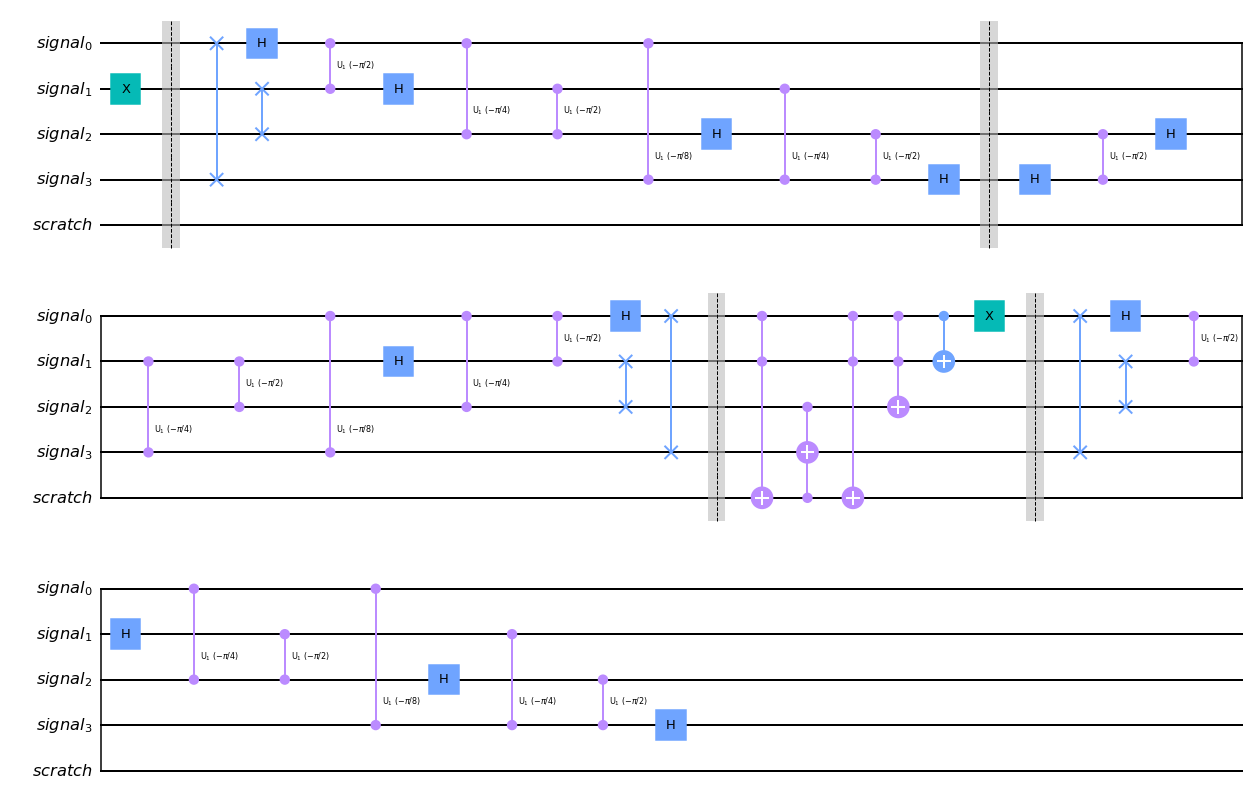

In [11]:
outputstate = result.get_statevector(qc, decimals=3)
for i,amp in enumerate(outputstate):
    if abs(amp) > 0.000001:
        prob = abs(amp) * abs(amp)
        print('|{}> {} probability = {}%'.format(i, amp, round(prob * 100, 5)))
qc.draw()        # draw the circuit